In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc 
import math as Math

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import random
import os
import sys

sys.path.insert(0, "/content/sample_data/")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm

class load_data(Dataset):
    def __init__(self, x, y):
        self.length = x.shape[0]
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.length


# A simple utility function for converting pytorch tensors to numpy
def tensor_to_numpy(data, device_type="cpu"):
    if device_type == "cpu":
        return data.detach().numpy()
    else:
        return data.cpu().detach().numpy()


# A simple utility function for converting numpy to pytorch tensors
def numpy_to_tensor(data, dtype="float", device="cuda"):
    if dtype=="float":
        return torch.tensor(data, dtype=torch.float).to(device)
    elif dtype=="long":
        return torch.tensor(data, dtype=torch.long).to(device)





seed = 1024
def reset_random_seeds():
   print("resetting seeds")
   os.environ['PYTHONHASHSEED']=str(seed)
#    tensorflow.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds()


#Supressing Warnings
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

path = '/content/sample_data/' # Path of file
filePath = path + 'IMDDataTillLandfall_moreFeatures2.csv'
data = pd.read_csv(filePath, index_col=0)

faniData = data[data['cyclone_id'].str.contains('2019-2')]
print('faniData Shape', faniData.shape)
# bulbulData = data[data['cyclone_id'].str.contains('2019-9')]
# print('bulbulData Shape', bulbulData.shape)
# gajaData = data[data['cyclone_id'].str.contains('2018-13')]
# print('gajaData Shape', gajaData.shape)

#Removing Fani, Bulbul, Gaja data from dataset
data = data[~data['cyclone_id'].str.contains('2019_2')]
# data = data[~data['cyclone_id'].str.contains('2019_9')]
# data = data[~data['cyclone_id'].str.contains('2018_13')]

print('data  Shape', data.shape)


#Normalizing features
scalers = {}
# columnsToNormalize = ['ecp','sst','distance','direction','mssw','lati','long']
# columnsToNormalize = ['ecp','sst','distance','direction','lati','long', 'season', 'pd','diam', 'grade']
# columnsToNormalize = ['cino', 'ecp', 'mssw', 'pd', 'distance', 'direction', 'lati', 'long']
# columnsToNormalize = [ 'mssw', 'pd', 'grade', 'distance', 'direction', 'lati']


# gc
# columnsToNormalize = ['mssw', 'pd', 'grade', 'oci', 'diam', 'distance', 'direction', 'lati']

# mutual information
columnsToNormalize = ['long', 'cino', 'ecp', 'mssw', 'pd', 'sst', 'distance', 'direction', 'lati']




for col in columnsToNormalize:
  scaler = StandardScaler()
  data[[col]] = scaler.fit_transform(data[[col]])
  scalers[col] =  scaler

data_pad = []

for key in np.unique(data['cyclone_id']):
    data_pad += [data[ data.loc[:, 'cyclone_id'] == key].loc[:, [ 'long', 'cino', 'ecp', 'mssw', 'pd', 'sst', 'distance', 'direction', 'lati']].values]

#Normalizing the features of Fani, Gaja, Bulbul with same scalers
for col in columnsToNormalize:
  scaler = scalers[col]
  faniData[[col]] = scaler.transform(faniData[[col]])

data_padF = []
data_padF += [faniData.loc[:, [ 'long', 'cino', 'ecp', 'mssw', 'pd', 'sst', 'distance', 'direction', 'lati']].values]

# for col in columnsToNormalize:
#   scaler = scalers[col]
#   bulbulData[[col]] = scaler.transform(bulbulData[[col]])

# data_padB = []
# data_padB += [bulbulData.loc[:, ['cino', 'ecp', 'mssw', 'pd', 'distance', 'direction', 'lati', 'long']].values]


# for col in columnsToNormalize:
#   scaler = scalers[col]
#   gajaData[[col]] = scaler.transform(gajaData[[col]])

# data_padG = []
# data_padG += [gajaData.loc[:, ['cino', 'ecp', 'mssw', 'pd', 'distance', 'direction', 'lati', 'long']].values]


#Preapring training dataset
def load_dataLati(data_pad, trainPoints ,amount_of_features):
    X = []
    y = []
    for cdata in data_pad:
      length = len(cdata)
      diff = length - trainPoints
      if diff > 0:
        yy = cdata[length-1][-1]
        for i in range(diff):
          cc = cdata[i : i + trainPoints]
          X.append(cc)
          y.append(yy)
    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], amount_of_features)) 
    #y_train = np.reshape(y, (y.shape[0], y.shape[1], 1))
    return [x_train, y]

def build_model(feature_count, loader_train, device, epochs):
    model = HSM1(device, feature_count, 64)
    model = model.to(device)
    print(model.parameters)
    criterion = nn.MSELoss()
    # Define optimizer
    # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    optimizer = optim.Adamax(model.parameters(), lr=0.001)


    for epoch in tqdm(range(epochs)):
        # print("\n\nEpoch: ", epoch+1, "\n-----------------")
        running_loss = 0
        
        for index, data in enumerate(loader_train):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #print(inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs).squeeze()
            # Compute loss for each timestep
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss+= loss.item()
        if (epoch+1)%10 == 0:
            print("Training loss: ", running_loss/len(loader_train))
    return model


def get_pred(model, device, loader):
    actual, preds = list(), list()
    # Make sure no gradients are being used during evaluation
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            labels = tensor_to_numpy(labels, device)
            pred = model(inputs).squeeze()
            pred = tensor_to_numpy(pred, device)
            actual.extend(labels)
            preds.extend(pred)
    return actual, preds

import torch.nn.functional as F


# relu
def new(x):
  relu1 = nn.ReLU(inplace=False)
  return relu1(x)


# # mish activation
# def new(x):
#     return 1.5*x* (torch.tanh(F.softplus(x)))
#     #return x/(1+tf.exp(-2*x))


# swish activation
# def new(x):
#     return 0.5*x*(1 + torch.tanh(x))
#     #return x/(1+tf.exp(-2*x))


feature_count = 9
trains = [4, 6, 8, 12]
# trains = [12]

resetting seeds
faniData Shape (58, 14)
data  Shape (3485, 14)


In [ ]:
# DILATED RNN

In [ ]:
class HSM1_layer(nn.Module):
    def __init__(self, dilation, input_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=None, return_sequences=True):
        # Define all the variables required
        super(HSM1_layer, self).__init__()
        self.dilation = dilation
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.use_gru = use_gru
        self.use_lstm = use_lstm
        self.use_rnn = use_rnn
        self.device = device
        self.return_sequences = return_sequences

        if self.use_gru == True:
            self.rnn = nn.GRU(self.input_dim, self.hidden_dim, batch_first=True)
        elif self.use_lstm == True:
            self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, batch_first=True)
        elif self.use_rnn == True:
            self.rnn = nn.RNN(self.input_dim, self.hidden_dim, batch_first=True)

    def forward(self, data):
        final_out = self._cell_output(data, self.rnn)
        if not self.return_sequences:
            return final_out[:,-1,:]
        else:
            return final_out

    def _cell_output(self, data, cell):
        output = self.drnn_layer(cell, data)
        return output
    
    def drnn_layer(self, cell, data):
        batch_size = data.shape[0]
        n_steps = data.shape[1]
        hidden_size = cell.hidden_size

        #print("\n======================= DILATION:", self.dilation, "=====================================")

        data = self._pad_inputs(data, batch_size, n_steps)
        #print("After Padding:", data.shape)
        data = self._prepare_inputs(data)
        data = self._apply_cell(data, cell)
        #print("After Applying cell:", data.shape)
        data = self._split_outputs(data, batch_size, hidden_size)
        #print("After Splitting outputs:", data.shape)
        outputs = self._unpad_outputs(data, n_steps)
        #print("After Unpadding:", outputs.shape)
        #print("\n")

        return outputs
    
    def _apply_cell(self, data, cell):
        data, _ = cell(data)
        return data

    def _unpad_outputs(self, data, n_steps):
        return data[:,:n_steps,:]

    def _split_outputs(self, data, batch_size, hidden_size):
        n_steps = data.shape[1]*self.dilation
        numerator = data.shape[1]
        new_data = torch.reshape(data, (batch_size, n_steps, hidden_size))
        new_data = torch.cat([new_data[:, i::numerator, :] for i in range(numerator)], dim=1)
        return new_data

    def _pad_inputs(self, data, batch_size, n_steps):
        is_even = (n_steps % self.dilation) == 0

        if not is_even:
            dilated_steps = n_steps // self.dilation + 1
            zeros_ = torch.zeros(batch_size, dilated_steps * self.dilation - data.shape[1], data.shape[2]).to(self.device)
            data = torch.cat((data, zeros_), dim=1)
        else:
            dilated_steps = n_steps // self.dilation

        return data

    def _prepare_inputs(self, data):
        batch_size = data.shape[0]
        new_data = torch.cat([data[:, i::self.dilation, :] for i in range(self.dilation)], dim=1)
        
        return torch.reshape(new_data, (self.dilation*batch_size, data.shape[1]//self.dilation, data.shape[2]))

In [ ]:
# Initialize Model

In [ ]:
# Create an HSM1 model
class HSM1(nn.Module):
    def __init__(self, device, input_dim, hidden_dim):
        super(HSM1, self).__init__()
        self.layer1 = HSM1_layer(1, input_dim, 512,  use_gru=True, use_lstm=False, use_rnn=False, device=device, return_sequences=True)
        self.layer2 = HSM1_layer(2, 512, 256,  use_gru=True, use_lstm=False, use_rnn=False, device=device, return_sequences=True)
        self.layer3 = HSM1_layer(4, 256, 128, use_gru=True, use_lstm=False, use_rnn=False, device=device, return_sequences=False)
        # self.layer4 = HSM1_layer(8, hidden_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=device, return_sequences=True)
        # self.layer5 = HSM1_layer(16, hidden_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=device, return_sequences=True)
        # self.layer6 = HSM1_layer(32, hidden_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=device, return_sequences=True)
        # self.layer7 = HSM1_layer(64, hidden_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=device, return_sequences=True)
        # self.layer8 = HSM1_layer(128, hidden_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=device, return_sequences=True)
        # self.layer9 = HSM1_layer(256, hidden_dim, hidden_dim, use_gru=False, use_lstm=False, use_rnn=True, device=device, return_sequences=False)
        self.linear = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = new(x)
        x = self.layer2(x)
        x = new(x)
        x = self.layer3(x)
        x = new(x)
        # x = self.layer4(x)
        # x = self.layer5(x)
        # x = self.layer6(x)
        # x = self.layer7(x)
        # x = self.layer8(x)
        # x = self.layer9(x)
        x = self.linear(x)
        return x

In [ ]:
# rest of the code

In [ ]:
def getMaeRmse(predictions, y_test, scalers):
  length = len(predictions)
  latiScaler = scalers['lati']
#   longScaler = scalers['long']
  #Extracting predicted and acutal latis
  latisP = predictions
#   longsP = predictions[:,1]
  latisA = y_test
#   longsA = y_test[:,1]

  latisA = np.reshape(latisA,(length,1))
#   longsA = np.reshape(longsA,(length,1))
  latisP = np.reshape(latisP,(length,1))
#   longsP = np.reshape(longsP,(length,1))

  #Getting actual values of latitiude/longitude
  latisA = latiScaler.inverse_transform(latisA)
#   longsA = longScaler.inverse_transform(longsA)
  latisP = latiScaler.inverse_transform(latisP)
#   longsP = longScaler.inverse_transform(longsP)

  testScorela = mean_squared_error(latisA, latisP)
#   testScorelo = mean_squared_error(longsA, longsP)

  testScorelaMae = mean_absolute_error(latisA, latisP)
#   testScoreloMae = mean_absolute_error(longsA, longsP)

#   return np.sqrt(testScorela), np.sqrt(testScorelo), testScorelaMae, testScoreloMae
  return np.sqrt(testScorela), testScorelaMae



In [ ]:
# def getDistance(predictions, y_test, scalers):
#   length = len(predictions)
#   latiScaler = scalers['lati']
#   longScaler = scalers['long']
#   latisP = predictions[:,0]
#   longsP = predictions[:,1]
#   latisA = y_test[:,0]
#   longsA = y_test[:,1]

#   latisA = np.reshape(latisA,(length,1))
#   longsA = np.reshape(longsA,(length,1))
#   latisP = np.reshape(latisP,(length,1))
#   longsP = np.reshape(longsP,(length,1))

#   latisA = latiScaler.inverse_transform(latisA)
#   longsA = longScaler.inverse_transform(longsA)
#   latisP = latiScaler.inverse_transform(latisP)
#   longsP = longScaler.inverse_transform(longsP)
#   dist = 0
#   distM = 0
#   for i in range(length):
#     actualCor = [latisA[i][0], longsA[i][0]]
#     predictedCor = [latisP[i][0], longsP[i][0]]
#     dist = dist + vc(actualCor, predictedCor).kilometers
#     distM = distM + vc(actualCor, predictedCor).miles

#   return dist/length, distM/length


In [ ]:
for i in range(len(trains)):
  trainPoints = trains[i]
  print("===========================================================")
  print("T (size of training point) =   ", trainPoints)
  X, y = load_dataLati(data_pad, trainPoints, feature_count)
  XF, yF = load_dataLati(data_padF, trainPoints, feature_count)
#   XG, yG = load_dataLati(data_padG, trainPoints, feature_count)
#   XB, yB = load_dataLati(data_padB, trainPoints, feature_count)

  datasetF = load_data(numpy_to_tensor(XF, "float", device), numpy_to_tensor(yF, "float", device))
  

  loaderF = DataLoader(dataset=datasetF, batch_size=256, shuffle=False, num_workers=0)


  X, y = shuffle(X, y, random_state=seed)

  print("No of train points", X.shape)

  kf = KFold(n_splits=5, shuffle=True,  random_state=seed)

  scoresla = []
  scoresFla = []
#   scoresGla = []
#   scoresBla = []

  scoreslaMae = []
  scoresFlaMae = []
#   scoresGlaMae = []
#   scoresBlaMae = []
    
#   scoreslo = []
#   scoresFlo = []
#   scoresGlo = []
#   scoresBlo = []

#   scoresloMae = []
#   scoresFloMae = []
#   scoresGloMae = []
#   scoresBloMae = []

#   scoresMi = []
#   scoresFMi = []
#   scoresGMi = []
#   scoresBMi = []

#   scoresKm = []
#   scoresFKm = []
#   scoresGKm = []
#   scoresBKm = []

  for train_index, test_index in kf.split(X):
      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index]
        
      dataset_train = load_data(numpy_to_tensor(X_train, "float", device), numpy_to_tensor(y_train, "float", device))
      dataset_test = load_data(numpy_to_tensor(X_test, "float", device), numpy_to_tensor(y_test, "float", device))

      loader_train = DataLoader(dataset=dataset_train, batch_size=64, shuffle=True, num_workers=0)
      loader_test = DataLoader(dataset=dataset_test, batch_size=512, shuffle=False, num_workers=0)

    

      model = build_model(feature_count, loader_train, device, epochs = 250)
      
      
        
      y_test, predictions = get_pred(model, device, loader_test)
      yF, predictionsF = get_pred(model, device, loaderF)
          
      
    
#       predictions = model.predict(X_test)
#       predictionsF = model.predict(XF)
#       predictionsG = model.predict(XG)
#       predictionsB = model.predict(XB)

      rmsela, msela = getMaeRmse(predictions, y_test, scalers)
      rmselaF, mselaF = getMaeRmse(predictionsF, yF, scalers)
#       rmselaG, mselaG = getMaeRmse(predictionsG, yG, scalers)
#       rmselaB, mselaB = getMaeRmse(predictionsB, yB, scalers)

#       distKm, distMi = getDistance(predictions, y_test, scalers)
#       distKmF, distMiF = getDistance(predictionsF, yF, scalers)
#       distKmG, distMiG = getDistance(predictionsG, yG, scalers)
#       distKmB, distMiB = getDistance(predictionsB, yB, scalers)

#       scoresMi.append(distMi)
#       scoresFMi.append(distMiF)
#       scoresGMi.append(distMiG)
#       scoresBMi.append(distMiB)

#       scoresKm.append(distKm)
#       scoresFKm.append(distKmF)
#       scoresGKm.append(distKmG)
#       scoresBKm.append(distKmB)

      scoresla.append(rmsela)
      scoresFla.append(rmselaF)
#       scoresGla.append(rmselaG)
#       scoresBla.append(rmselaB)
    
#       scoreslo.append(rmselo)
#       scoresFlo.append(rmseloF)
#       scoresGlo.append(rmseloG)
#       scoresBlo.append(rmseloB)

      scoreslaMae.append(msela)
      scoresFlaMae.append(mselaF)
#       scoresGlaMae.append(mselaG)
#       scoresBlaMae.append(mselaB)
    
#       scoresloMae.append(mselo)
#       scoresFloMae.append(mseloF)
#       scoresGloMae.append(mseloG)
#       scoresBloMae.append(mseloB)

      print('scores latitude  RMSE ', scoresla)
#       print('scores longitude  RMSE', scoreslo)
    
      print('scores latitude Mae ', scoreslaMae)
#       print('scores longitude  Mae', scoresloMae)

#       print('distance Miles  ', scoresMi)
#       print('distances KiloMeters  ', scoresKm)

  print("5 fold accuracy Lati RMSE ",np.array(scoresla).mean())
  print("5 fold accuracy Lati Fani RMSE ", np.array(scoresFla).mean())
#   print("5 fold accuracy Lati Gaja RMSE ", np.array(scoresGla).mean())
#   print("5 fold accuracy Lati Bulbul RMSE ", np.array(scoresBla).mean())
    
#   print("5 fold accuracy Long RMSE ",np.array(scoreslo).mean())
#   print("5 fold accuracy Long Fani RMSE ", np.array(scoresFlo).mean())
#   print("5 fold accuracy Long Gaja RMSE ", np.array(scoresGlo).mean())
#   print("5 fold accuracy Long Bulbul RMSE ", np.array(scoresBlo).mean())

  print("5 fold accuracy  Lati MAE",np.array(scoreslaMae).mean())
  print("5 fold accuracy  Lati  Fani MAE", np.array(scoresFlaMae).mean())
#   print("5 fold accuracy  Lati Gaja  MAE", np.array(scoresGlaMae).mean())
#   print("5 fold accuracy  Lati Bulbul MAE", np.array(scoresBlaMae).mean())
    
#   print("5 fold accuracy Long MAE",np.array(scoresloMae).mean())
#   print("5 fold accuracy  Long  Fani MAE", np.array(scoresFloMae).mean())
#   print("5 fold accuracy  Lati  Gaja MAE", np.array(scoresGloMae).mean())
#   print("5 fold accuracy  Lati  Bulbul MAE", np.array(scoresBloMae).mean())

  # print("5 fold distance average Miles ",np.array(scoresMi).mean())
  # print("Fani average error Miles ", np.array(scoresFMi).mean())
  # print("Gaja average error Miles ", np.array(scoresGMi).mean())
  # print("Bulbul average error Miles ", np.array(scoresBMi).mean())

#   print("5 fold distance average Kilometers ",np.array(scoresKm).mean())
#   print("5 fold distance average Fani Kilometers ", np.array(scoresFKm).mean())
#   print("5 fold distance average Gaja Kilometers ", np.array(scoresGKm).mean())
#   print("5 fold distance average Bulbul Kilometers ", np.array(scoresBKm).mean())


T (size of training point) =    4
No of train points (2820, 4, 9)
<bound method Module.parameters of HSM1(
  (layer1): HSM1_layer(
    (rnn): GRU(9, 512, batch_first=True)
  )
  (layer2): HSM1_layer(
    (rnn): GRU(512, 256, batch_first=True)
  )
  (layer3): HSM1_layer(
    (rnn): GRU(256, 128, batch_first=True)
  )
  (linear): Linear(in_features=128, out_features=1, bias=True)
)>


  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.3003194998535845
Training loss:  0.20051728644304806
Training loss:  0.13585079378551906
Training loss:  0.08220281307068136
Training loss:  0.05597963815348016
Training loss:  0.03375534635658065
Training loss:  0.02101536972137789
Training loss:  0.017700591176334355
Training loss:  0.014347725651330419
Training loss:  0.007910716075760623
Training loss:  0.008162388228811324
Training loss:  0.007131070687642528
Training loss:  0.005144506143147333
Training loss:  0.008238040376454592
Training loss:  0.005283670305895309
Training loss:  0.002969637429082973
Training loss:  0.0029225495980224675
Training loss:  0.0030133751182196042
Training loss:  0.0015966861909772786
Training loss:  0.003912397291666518
Training loss:  0.0025939088858043156
Training loss:  0.002336635496855403
Training loss:  0.0022687720290074744
Training loss:  0.001898394275081551
Training loss:  0.0020774214741929122
scores latitude  RMSE  [1.054743]
scores latitude Mae  [0.59859556]
<bound me

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.2988082625799709
Training loss:  0.19580127836929428
Training loss:  0.13086095535092884
Training loss:  0.07829945637947983
Training loss:  0.04792529080683986
Training loss:  0.04656059191458755
Training loss:  0.021598334243107174
Training loss:  0.012577437549932964
Training loss:  0.014690376947530441
Training loss:  0.008061224853412973
Training loss:  0.015208094406666027
Training loss:  0.004955404360468189
Training loss:  0.012415579028634561
Training loss:  0.0050668049241519636
Training loss:  0.006289765290502045
Training loss:  0.0041055675505453516
Training loss:  0.004036728512599236
Training loss:  0.005022763074116988
Training loss:  0.0041048449412402176
Training loss:  0.0030737697023950103
Training loss:  0.002217759727500379
Training loss:  0.00163513352163136
Training loss:  0.0025644585063370564
Training loss:  0.003596660590523647
Training loss:  0.0004563578832959239
scores latitude  RMSE  [1.054743, 1.4154323]
scores latitude Mae  [0.59859556

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.30054088599152035
Training loss:  0.2037993125203583
Training loss:  0.12330571034302314
Training loss:  0.07901593996211886
Training loss:  0.05340755430774556
Training loss:  0.032622217666357756
Training loss:  0.02597156909501387
Training loss:  0.0156963586082889
Training loss:  0.014027792533549169
Training loss:  0.009805985648805896
Training loss:  0.009132163767288957
Training loss:  0.005833375190074245
Training loss:  0.0049952582986507975
Training loss:  0.006279749866937184
Training loss:  0.003115258334825436
Training loss:  0.0021738444694266138
Training loss:  0.0037020741341014705
Training loss:  0.0037546726622773954
Training loss:  0.0022087755464276094
Training loss:  0.005650030203267104
Training loss:  0.001758084034210899
Training loss:  0.005097590322192345
Training loss:  0.002351823081779811
Training loss:  0.0014533814084845493
Training loss:  0.005053932552174147
scores latitude  RMSE  [1.054743, 1.4154323, 1.2056912]
scores latitude Mae  [

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.3083054195675585
Training loss:  0.19933286474810707
Training loss:  0.12410465876261394
Training loss:  0.09090994091497527
Training loss:  0.0525286884771453
Training loss:  0.030463009658786986
Training loss:  0.02187426039017737
Training loss:  0.014399866495902339
Training loss:  0.015311840171408322
Training loss:  0.015210859930246241
Training loss:  0.009296092864436408
Training loss:  0.00716787302452657
Training loss:  0.01251286984835234
Training loss:  0.00396536633424047
Training loss:  0.0062248062976222075
Training loss:  0.003554262511897832
Training loss:  0.002094121365290549
Training loss:  0.0033778282684377497
Training loss:  0.001847811295495679
Training loss:  0.0010730290264796673
Training loss:  0.0010644872268635987
Training loss:  0.0024647185653318754
Training loss:  0.003060361415716923
Training loss:  0.004329123113873518
Training loss:  0.002028624051793789
scores latitude  RMSE  [1.054743, 1.4154323, 1.2056912, 0.8713659]
scores latitud

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.2942911552058326
Training loss:  0.20026149393783677
Training loss:  0.11935623093611664
Training loss:  0.07458638172182772
Training loss:  0.04841988409558932
Training loss:  0.038541107490244836
Training loss:  0.02066854216779272
Training loss:  0.017637657441405788
Training loss:  0.013865687341118852
Training loss:  0.010271163954813447
Training loss:  0.007283999041343729
Training loss:  0.00708912031000687
Training loss:  0.007120911963284016
Training loss:  0.004469964420422912
Training loss:  0.005259221743067933
Training loss:  0.003581700296813829
Training loss:  0.0036649102047603163
Training loss:  0.0027382036205381155
Training loss:  0.002294936888372629
Training loss:  0.001675557223885941
Training loss:  0.0024810318815677115
Training loss:  0.0010510612531409909
Training loss:  0.0012243940646941257
Training loss:  0.00027929397401749156
Training loss:  0.0004364676832564227
scores latitude  RMSE  [1.054743, 1.4154323, 1.2056912, 0.8713659, 1.290729

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.27442831359803677
Training loss:  0.15802796580828726
Training loss:  0.0864304139977321
Training loss:  0.04265904286876321
Training loss:  0.03153468680102378
Training loss:  0.017104815487982705
Training loss:  0.009738659209688194
Training loss:  0.007613950801896863
Training loss:  0.005184007648495026
Training loss:  0.013657476039952599
Training loss:  0.004434193797351327
Training loss:  0.0037339524787967093
Training loss:  0.0060081959964009
Training loss:  0.001070600881575956
Training loss:  0.0055986418956308626
Training loss:  0.0011689061120705446
Training loss:  0.0010358550443925196
Training loss:  0.0016859165243658936
Training loss:  0.005603620506008156
Training loss:  0.00037069320387672633
Training loss:  0.0026737848347693216
Training loss:  0.0025734533664945047
Training loss:  0.0021355011631385423
Training loss:  0.0002621051771711791
Training loss:  0.0026959589631587733
scores latitude  RMSE  [0.7944303]
scores latitude Mae  [0.42166895]
<b

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.27229403983801603
Training loss:  0.15307894395664334
Training loss:  0.08105838519986719
Training loss:  0.047090167645365
Training loss:  0.025351124233566225
Training loss:  0.025822055962635204
Training loss:  0.008613353973487392
Training loss:  0.007236225661472417
Training loss:  0.003986330615589395
Training loss:  0.006350547097099479
Training loss:  0.0036865020447294228
Training loss:  0.0061387575551634654
Training loss:  0.004477012829738669
Training loss:  0.001608218710316578
Training loss:  0.000827418829430826
Training loss:  0.004623220687790308
Training loss:  0.0005564125913224416
Training loss:  0.000562244291359093
Training loss:  0.0024476484504702967
Training loss:  0.0029137475466995966
Training loss:  0.0010823518969118595
Training loss:  0.002135017693944974
Training loss:  0.0008203016132029006
Training loss:  0.002465849396685371
Training loss:  9.104733624099026e-05
scores latitude  RMSE  [0.7944303, 0.5988285]
scores latitude Mae  [0.421

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.2605209778994322
Training loss:  0.15291257738135755
Training loss:  0.08409787598066032
Training loss:  0.04726445855339989
Training loss:  0.02978012670064345
Training loss:  0.02012612286489457
Training loss:  0.011077394607127644
Training loss:  0.007252871568198316
Training loss:  0.004594345977238845
Training loss:  0.00334071052930085
Training loss:  0.006400206679245457
Training loss:  0.005166299219126813
Training loss:  0.0011533735996636096
Training loss:  0.002288206149387406
Training loss:  0.0011894503968505887
Training loss:  0.00300815659284126
Training loss:  0.001910693204990821
Training loss:  0.009108968486543745
Training loss:  0.0006352460186462849
Training loss:  0.0034220623711007647
Training loss:  0.0029631432553287596
Training loss:  0.0021589567804767285
Training loss:  0.001110778746806318
Training loss:  0.0013428964830382029
Training loss:  0.0021610810472338926
scores latitude  RMSE  [0.7944303, 0.5988285, 0.60087097]
scores latitude Ma

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.24270914820954204
Training loss:  0.15696298540569842
Training loss:  0.08704740938264877
Training loss:  0.05632065096870065
Training loss:  0.024743736430536956
Training loss:  0.012728030516882427
Training loss:  0.013828869952703826
Training loss:  0.00707827909354819
Training loss:  0.006016821716912091
Training loss:  0.005869670909305569
Training loss:  0.0016251471679424867
Training loss:  0.0046420715807471424
Training loss:  0.005977912864182144
Training loss:  0.002607641938084271
Training loss:  0.0010744504470494576
Training loss:  0.0013482739213941386
Training loss:  0.0017459935588703956
Training loss:  0.0028741288369928952
Training loss:  0.00035945250101576676
Training loss:  0.0020807371165574295
Training loss:  0.0016209853274631314
Training loss:  0.00017115506557274784
Training loss:  0.00019375183819647646
Training loss:  0.0034396204646327533
Training loss:  0.002989592947415076
scores latitude  RMSE  [0.7944303, 0.5988285, 0.60087097, 0.85128

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.25316057819873095
Training loss:  0.14661664050072432
Training loss:  0.08121138153364882
Training loss:  0.03907968138810247
Training loss:  0.024941885872976854
Training loss:  0.015680088836234063
Training loss:  0.010996943005011417
Training loss:  0.012173106370028108
Training loss:  0.004599103660439141
Training loss:  0.008354439531103708
Training loss:  0.003210381830285769
Training loss:  0.003106078518612776
Training loss:  0.010528362909099087
Training loss:  0.001385191060762736
Training loss:  0.003626850520959124
Training loss:  0.0023222339441417716
Training loss:  0.001029386643494945
Training loss:  0.004430031665833667
Training loss:  0.0009007997614389751
Training loss:  0.0027203903409827035
Training loss:  0.0015707834500062745
Training loss:  0.0005449317877719295
Training loss:  0.0006276409285419504
Training loss:  0.0015229475993692176
Training loss:  0.0007587705131300027
scores latitude  RMSE  [0.7944303, 0.5988285, 0.60087097, 0.851288, 1.0

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.24083628890843228
Training loss:  0.12672416197842565
Training loss:  0.06716395118113222
Training loss:  0.035168139585133255
Training loss:  0.019704198721667815
Training loss:  0.007929797926596526
Training loss:  0.006382450035869561
Training loss:  0.003998145838428674
Training loss:  0.003398506444525616
Training loss:  0.00409273660324257
Training loss:  0.004350182801035458
Training loss:  0.001370813617290094
Training loss:  0.0009230461116109429
Training loss:  0.002592226165218343
Training loss:  0.0030310612597406424
Training loss:  0.0003316450958413168
Training loss:  0.0002650706200852412
Training loss:  0.0004149235329381993
Training loss:  0.001138709882948676
Training loss:  0.0012294785059378322
Training loss:  0.0025421962511308236
Training loss:  0.00039721560084405514
Training loss:  0.0029326203471884645
Training loss:  0.0005415978596609985
Training loss:  0.003461110172793269
scores latitude  RMSE  [0.48426336]
scores latitude Mae  [0.32035333

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.22102274822777715
Training loss:  0.11539215144926104
Training loss:  0.06743786291315637
Training loss:  0.03358870590555257
Training loss:  0.012886166090852228
Training loss:  0.014835471576400873
Training loss:  0.006198990833142708
Training loss:  0.0048851734990703645
Training loss:  0.005371721774532363
Training loss:  0.0029356435085807382
Training loss:  0.005001657160705534
Training loss:  0.002493411455110743
Training loss:  0.005728366359233342
Training loss:  0.0006021407075579567
Training loss:  0.003042228122498712
Training loss:  0.0005092569626867771
Training loss:  0.00017535390587250605
Training loss:  0.0025332773883088395
Training loss:  0.002692448155922366
Training loss:  0.0007804168251760561
Training loss:  0.0026814841649270265
Training loss:  0.0004641355671679023
Training loss:  0.0028198924887090407
Training loss:  0.00028117384073115756
Training loss:  0.0004970143260113124
scores latitude  RMSE  [0.48426336, 0.4993192]
scores latitude Ma

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.23125446716259265
Training loss:  0.12223309124338216
Training loss:  0.06421344239136269
Training loss:  0.035551205598588646
Training loss:  0.015748154404091424
Training loss:  0.008768419060727646
Training loss:  0.006042365667185393
Training loss:  0.009534943816733771
Training loss:  0.005055853816006204
Training loss:  0.0030664126147869333
Training loss:  0.004402706070385617
Training loss:  0.0017006256705920759
Training loss:  0.0039749687401063995
Training loss:  0.0008173906766199346
Training loss:  0.006778151230436975
Training loss:  0.0008905255235731602
Training loss:  0.002074172031856945
Training loss:  0.0016591454422550983
Training loss:  0.008408860512206266
Training loss:  0.00016909552128897208
Training loss:  0.00010939381047200155
Training loss:  0.0018904958972065099
Training loss:  0.0007713005219682537
Training loss:  0.0004995749492583604
Training loss:  0.0009834965337710134
scores latitude  RMSE  [0.48426336, 0.4993192, 0.91540664]
score

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.2053663257894845
Training loss:  0.10907604892192216
Training loss:  0.06156312173296665
Training loss:  0.029546281965128308
Training loss:  0.02052177980156808
Training loss:  0.0068566010831373515
Training loss:  0.011925945861329293
Training loss:  0.0027078562215420193
Training loss:  0.003167398265916212
Training loss:  0.0074682506443611504
Training loss:  0.002368175243990945
Training loss:  0.0035690394599504514
Training loss:  0.0014722830583823138
Training loss:  0.0019484500376636099
Training loss:  0.0008375532804699294
Training loss:  0.00037729220840164684
Training loss:  0.0027311600720638343
Training loss:  0.0019513331353664398
Training loss:  0.0008712302891393032
Training loss:  0.001182599816118078
Training loss:  0.0009227583580248957
Training loss:  0.0023280397169934265
Training loss:  0.003763220493745958
Training loss:  0.00012302264753841506
Training loss:  0.0006313987481728967
scores latitude  RMSE  [0.48426336, 0.4993192, 0.91540664, 0.69

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.22124068079323606
Training loss:  0.12788782885362363
Training loss:  0.06760717966947062
Training loss:  0.032781068877927186
Training loss:  0.017053580971370483
Training loss:  0.009897142777155185
Training loss:  0.006825969907744178
Training loss:  0.0068559830783513085
Training loss:  0.004267899712933035
Training loss:  0.008198534933336336
Training loss:  0.0008467977559434828
Training loss:  0.0009289718863297382
Training loss:  0.0038376140713306337
Training loss:  0.0019471016150481742
Training loss:  0.0019192439102535617
Training loss:  0.0016353453513523884
Training loss:  0.001619907527567883
Training loss:  0.0024319126688200853
Training loss:  0.004286106093786657
Training loss:  0.00032793919772616234
Training loss:  0.002119045066326086
Training loss:  0.0002728357478566789
Training loss:  0.0005660167973536741
Training loss:  0.0011412134807524752
Training loss:  9.73395167263867e-05
scores latitude  RMSE  [0.48426336, 0.4993192, 0.91540664, 0.6926

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.21140043810009956
Training loss:  0.10996853600954637
Training loss:  0.07807345393424232
Training loss:  0.055511628122379385
Training loss:  0.03065194150743385
Training loss:  0.0226750971050933
Training loss:  0.013219908791749427
Training loss:  0.0157113451762901
Training loss:  0.007159153942969472
Training loss:  0.004862331309899067
Training loss:  0.0041813540932101505
Training loss:  0.007089620313005677
Training loss:  0.01997733211222415
Training loss:  0.0062072194802264375
Training loss:  0.0018082930970801196
Training loss:  0.005108067343826406
Training loss:  0.0024011657709100596
Training loss:  0.0024340775632178215
Training loss:  0.005797051468107384
Training loss:  0.0006653546115558129
Training loss:  0.0013655433504027314
Training loss:  0.007208459738952418
Training loss:  0.0007864503374245638
Training loss:  0.0006921525249102464
Training loss:  0.001270609318453353
scores latitude  RMSE  [0.34634638]
scores latitude Mae  [0.22101957]
<boun

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.21165614699323973
Training loss:  0.1351708592264913
Training loss:  0.1349387139392396
Training loss:  0.082221283732603
Training loss:  0.0705217180851226
Training loss:  0.06499351204062502
Training loss:  0.037418263809134565
Training loss:  0.0234242466200764
Training loss:  0.015946629864629358
Training loss:  0.02004630588150273
Training loss:  0.0068010190831652535
Training loss:  0.009664657118264586
Training loss:  0.006264791697806989
Training loss:  0.005235983873717487
Training loss:  0.0019866060611093417
Training loss:  0.0014744564614375122
Training loss:  0.008360415270241598
Training loss:  0.0014482871326132833
Training loss:  0.000824195846538108
Training loss:  0.002115386461809976
Training loss:  0.0023532454403418037
Training loss:  0.0022339101172595597
Training loss:  0.01349707974364378
Training loss:  0.0015279720222072986
Training loss:  0.0006656262618586576
scores latitude  RMSE  [0.34634638, 0.48505405]
scores latitude Mae  [0.22101957, 

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.19457656672845283
Training loss:  0.11856570715705554
Training loss:  0.08301945154865582
Training loss:  0.06933949321197967
Training loss:  0.02871792984660715
Training loss:  0.01776213520982613
Training loss:  0.013442993086452285
Training loss:  0.011173726040093849
Training loss:  0.012084318926402679
Training loss:  0.007367419893853366
Training loss:  0.012412334074421475
Training loss:  0.011104323474379877
Training loss:  0.002460887815686874
Training loss:  0.00227832382855316
Training loss:  0.009999500107369386
Training loss:  0.0022097201969396942
Training loss:  0.003117340869115045
Training loss:  0.0015084431009502925
Training loss:  0.004693433984963728
Training loss:  0.0032423411636652113
Training loss:  0.0012303297116886824
Training loss:  0.0016099709707001846
Training loss:  0.003376550341878707
Training loss:  0.0005927622053908029
Training loss:  0.0005900843733191626
scores latitude  RMSE  [0.34634638, 0.48505405, 0.7181903]
scores latitude 

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.19353907586385807
Training loss:  0.12390684708952904
Training loss:  0.07600649228940408
Training loss:  0.050424931570887566
Training loss:  0.020561008461906265
Training loss:  0.014170683881578347
Training loss:  0.013740963438370576
Training loss:  0.007435193343553692
Training loss:  0.005481025262270123
Training loss:  0.0034676880944365016
Training loss:  0.0029600573810360706
Training loss:  0.002899711051820001
Training loss:  0.0014043171104276553
Training loss:  0.0016061651258496568
Training loss:  0.003640818283505117
Training loss:  0.002071065168517331
Training loss:  0.002492101573807304
Training loss:  0.0015245998123039801
Training loss:  0.0009296398917892171
Training loss:  0.0006424000293918652
Training loss:  0.001751265794155188
Training loss:  0.001995886549896871
Training loss:  0.007185800883841391
Training loss:  0.000505433284464137
Training loss:  0.0005958432132805077
scores latitude  RMSE  [0.34634638, 0.48505405, 0.7181903, 0.27254733]

  0%|          | 0/250 [00:00<?, ?it/s]

Training loss:  0.1812748706433922
Training loss:  0.10126462423553069
Training loss:  0.06742255079249541
Training loss:  0.038357085160290204
Training loss:  0.02178421845504393
Training loss:  0.014150264983375868
Training loss:  0.007595084316562861
Training loss:  0.0057218812047115835
Training loss:  0.009874176379526034
Training loss:  0.003150869466480799
Training loss:  0.006573524267878383
Training loss:  0.001805328720365651
Training loss:  0.003305793293596556
Training loss:  0.002199587101737658
Training loss:  0.0014818193327907163
Training loss:  0.0019964308642859883
Training loss:  0.002375629652912418
Training loss:  0.001571095985127613
Training loss:  0.0023303082125494257
Training loss:  0.0010859225294552743
Training loss:  0.0006251211707422044
Training loss:  0.0011176393284889248
Training loss:  0.001847362276748754
Training loss:  0.0002335084924804202
Training loss:  0.0009571234816879345
scores latitude  RMSE  [0.34634638, 0.48505405, 0.7181903, 0.27254733, 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generateing latitiude/longitude grpahs for Fani, Gaja and Bulbul
trainPoints = 8  # Graphs for T = 8
X, y = load_dataLati(data_pad, trainPoints, feature_count)
XF, yF = load_dataLati(data_padF, trainPoints, feature_count)
# XG, yG = load_dataLati(data_padG, trainPoints, feature_count)
# XB, yB = load_dataLati(data_padB, trainPoints, feature_count)
X, y = shuffle(X, y, random_state=seed)
model = build_model(feature_count, trainPoints)
model.fit(X, y, batch_size=512, epochs=150, verbose=0, shuffle = True)
predictionsF = model.predict(XF)
predictionsG = model.predict(XG)
predictionsB = model.predict(XB)

trainPoints  (T) =  8


<Figure size 720x720 with 0 Axes>

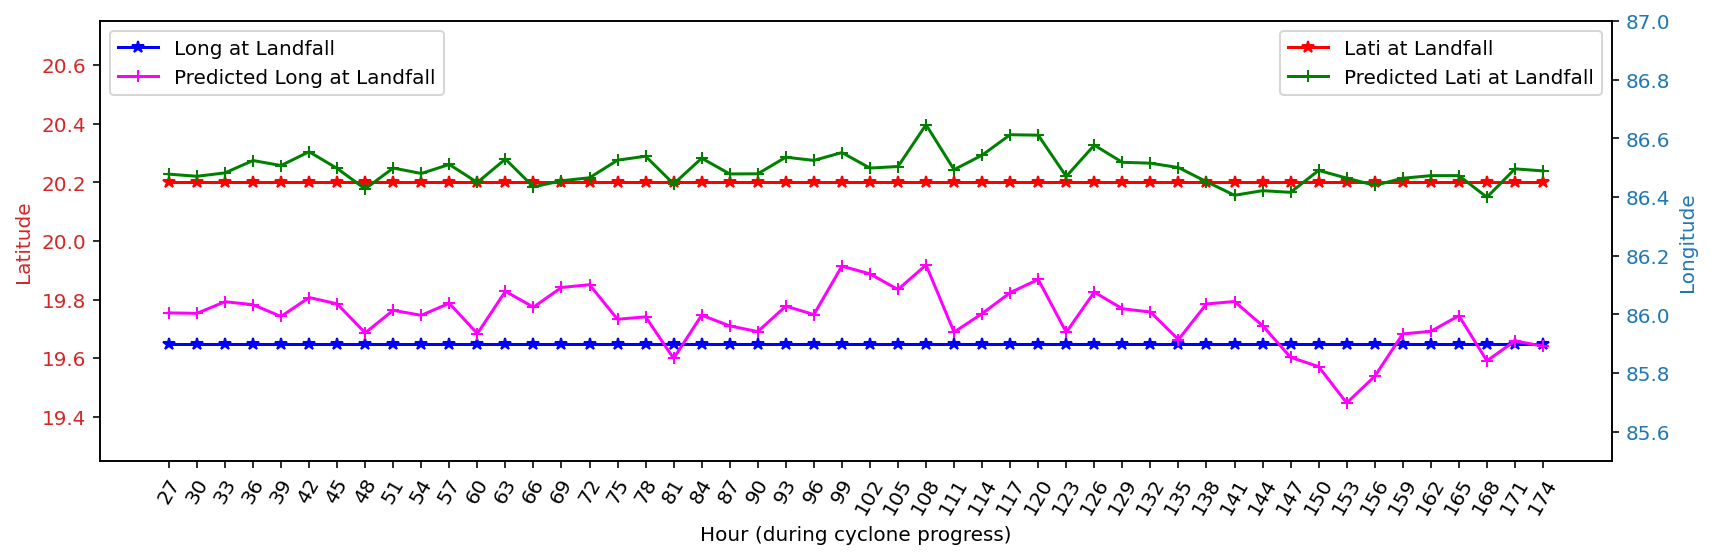

In [ ]:
# For Fani cyclone
print("trainPoints  (T) = ", trainPoints)
latiScaler = scalers['lati']
# longScaler = scalers['long']

lengthF = len(yF)

latisPF = predictionsF
# longsPF = predictionsF[:,1]
latisAF = yF
# longsAF = yF[:,1]


latisPF = np.reshape(latisPF,(lengthF,1))
# longsPF = np.reshape(longsPF,(lengthF,1))
latisAF = np.reshape(latisAF,(lengthF,1))
# longsAF = np.reshape(longsAF,(lengthF,1))

latisPF = latiScaler.inverse_transform(latisPF)
# longsPF = longScaler.inverse_transform(longsPF)
latisAF = latiScaler.inverse_transform(latisAF)
# longsAF = longScaler.inverse_transform(longsAF)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthF,lengthF)*3 + 8*3
color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Latitude', color=color)
ax1.plot(a, latisAF, marker = '*',label = "Lati at Landfall",color = 'red')
ax1.plot(a, latisPF, marker = '+',label = "Predicted Lati at Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((19.25,20.75))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Longitude', color=color)  # we already handled the x-label with ax1
ax2.plot(a, longsAF, marker = '*',label = "Long at Landfall",color = 'blue')
ax2.plot(a, longsPF, marker = '+',label = "Predicted Long at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((85.5,87))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=2)
plt.show()

In [ ]:
#Time to calculate 150 epochs
X, y = load_dataLati(data_pad, 4, feature_count)
X, y = shuffle(X, y, random_state=0)
model = build_model(feature_count, 4)
start = time.time()
model.fit(X, y, batch_size=512, epochs=150, verbose=0, shuffle = True)
end = time.time()
print("time (seconds) ", end-start)

time (seconds)  91.82479214668274


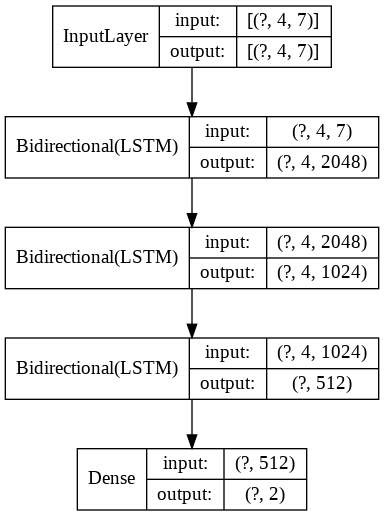

In [ ]:
#Plotting the Model structure
model = build_model(feature_count, 4)
X, y = load_dataLati(data_pad, 4, feature_count)
model.fit(X, y, batch_size=512, epochs=10, verbose=0, shuffle = True)
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=False)